In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ZeroPadding2D,
                          MaxPooling2D, Activation, Dense, Dropout, Flatten)
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
import os
import sys

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [4]:
def vgg16_mnist(MODEL_NAME, act):
    x = Input(shape = (28, 28, 1))
    y = ZeroPadding2D(padding = (2, 2))(x) 

    y = multiConvLayer(y, 64, 2, act) # size 32x32
    y = multiConvLayer(y, 128, 2, act) # size 16x16
    y = multiConvLayer(y, 256, 3, act) # size 8x8
    y = multiConvLayer(y, 512, 3, act) # size 4x4
    y = multiConvLayer(y, 512, 3, act) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation=act)(y)
    y = Dense(units = 4096, activation=act)(y)
    y = Dense(units = 10)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [5]:
def multiConvLayer(x, value, n, act):
    y = x
    for _ in range(n):
        y = Conv2D(value, (3, 3), padding = 'same')(y)
        y = Activation(act)(y)
    y = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(y)
    return y

In [6]:
def checkDir(modelName):
    # Used to create all necessary folders
    # Not implemented yet
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Used to save the logs
    if not os.path.exists('logs'):
        os.makedirs('logs')
        
    # Used to save the logs
    if not os.path.exists('images'):
        os.makedirs('images')
        
    if not os.path.exists('models/'+modelName):
        os.makedirs('models/'+modelName)
        
    if not os.path.exists('images/'+modelName):
        os.makedirs('images/'+modelName)

In [7]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    y_train = to_categorical(y_train) # encode one-hot vector
    y_test = to_categorical(y_test)

    num_of_test_data = 50000
    x_val = x_train[num_of_test_data:]
    y_val = y_train[num_of_test_data:]
    x_train = x_train[:num_of_test_data]
    y_train = y_train[:num_of_test_data]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [8]:
def save_model(model, modelName):
    # serialize model to JSON
    model_json = model.to_json()
    with open("models/" + modelName + "/model.json", "w") as json_file:
        json_file.write(model_json)
        
    # Save the model with best accuracy as final model
    mylist = os.listdir('models/'+modelName)
    if os.path.exists('models/' + modelName + '/' + 'model.h5'):
        os.remove('models/' + modelName + '/' + 'model.h5')
    os.rename('models/' + modelName + '/' +mylist[len(mylist)-1],'models/' + modelName + '/' + 'model.h5')
    
    mylist.remove(mylist[len(mylist)-1])
    
    while len(mylist) > 2:
        os.remove('models/' + modelName + '/' + mylist[len(mylist)-1])
        mylist.remove(mylist[len(mylist)-1])

    print("Saved model to disk")

In [9]:
def load_model(modelName):
    
    if os.path.isfile('models/' + modelName + '/model.json') and os.path.isfile('models/' + modelName + '/model.h5'):
        # Load json and create model
        json_file = open('models/' + modelName + '/model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        
        # Load weights into new model
        loaded_model.load_weights('models/' + modelName + '/model.h5')

        print("Loaded model from disk")
    else:
        print ("Model does not exist. Train it first!")
    

    return loaded_model

In [10]:
def generatePlots(history, model, test_data, modelName):
    # Generate Training/Validation plots
    acc_MNIST = history.history['accuracy']
    val_acc_MNIST = history.history['val_accuracy']
    loss_MNIST = history.history['loss']
    val_loss_MNIST = history.history['val_loss']
    epochs_graph = range(1, len(acc_MNIST) + 1)

    plt.figure()
    plt.title('Training and Validation Accuracy', fontsize = '24')
    plt.xlabel("Epochs", fontsize = '24')
    plt.ylabel("Accuracy", fontsize = '24')
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.plot(epochs_graph, acc_MNIST, 'red', label='Training accuracy')
    plt.plot(epochs_graph, val_acc_MNIST, 'blue', label='Validation accuracy')
    plt.legend()

    plt.savefig('images/'+ modelName + '/TrainingAndValidationAcc_' + modelName + '.png')

    plt.figure()
    plt.title('Training and Validation Loss', fontsize = '24')
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.xlabel("Epochs", fontsize = '24')
    plt.ylabel("Loss", fontsize = '24')
    plt.plot(epochs_graph, loss_MNIST, 'red', label='Training loss')
    plt.plot(epochs_graph, val_loss_MNIST, 'blue', label='Validation loss')
    plt.legend()

    plt.savefig('images/'+ modelName + '/TrainingAndValidationLoss_' + modelName + '.png')
    plt.show()

    Y_pred_MNIST = model.predict(test_data[0])
    Y_pred_classes_MNIST = np.argmax(Y_pred_MNIST, axis = 1) 
    Y_truth_MNIST = np.argmax(test_data[1], axis = 1) 

    confusion_mtx_MNIST = confusion_matrix(Y_truth_MNIST, Y_pred_classes_MNIST)

    f, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(confusion_mtx_MNIST, annot=True, linewidths=0.01, cmap="viridis", linecolor="gray", fmt= '.1f', ax = ax)
    plt.xlabel("Predicted Label", fontsize = 24)
    plt.ylabel("True Label", fontsize = 24)
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.title("Confusion Matrix", fontsize = '24')

    plt.savefig('images/'+ modelName + '/ConfusionMatrix_' + modelName + '.png')
    plt.show()

In [28]:
def main(arg, arg2 = None):
    # Define Adam Optimizer
    adam = Adam(lr=1e-4, decay=1e-6)
    
    tensorboard = TensorBoard(write_grads=True, write_images=True)
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    if arg == "vgg16-train-mnist":
        
        MODEL_NAME = "VGG16-MNIST"
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg16_mnist(MODEL_NAME, arg2)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=20, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "resnet152_train":
        MODEL_NAME = "resnet152-mnist"
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        training_data = list(training_data)
        val_data = list(val_data)
        test_data = list(test_data)
        
        # Pre-processing data - zero-padding so that it fits the minimum 32*32 size
        training_data[0] = np.pad(training_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        val_data[0] = np.pad(val_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        test_data[0] = np.pad(test_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')

        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        if arg2 == None:
            # Create the model architecture
            model = tf.keras.applications.ResNet152(weights=None, input_tensor=None,input_shape=(32,32,1), pooling=None, classes=10)
        elif arg2 != None:
            model = tf.keras.applications.ResNet152(weights=None, input_tensor=None,input_shape=(32,32,1), pooling=arg2, classes=10)
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=20, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "MobileNetV2_train":
        
        MODEL_NAME = "MobileNetV2-mnist"
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        training_data = list(training_data)
        val_data = list(val_data)
        test_data = list(test_data)
        
        # Pre-processing data - zero-padding so that it fits the minimum 32*32 size
        training_data[0] = np.pad(training_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        val_data[0] = np.pad(val_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        test_data[0] = np.pad(test_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        if arg2 == None:
            model = tf.keras.applications.MobileNetV2(input_shape=(32,32,1), alpha=1.0,weights=None,input_tensor=None,pooling=None,classes=10)
        else:
            model = tf.keras.applications.MobileNetV2(input_shape=(32,32,1), alpha=1.0,weights=None,input_tensor=None,pooling=arg2,classes=10)
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=20, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "test-vgg16-mnist":
        
        MODEL_NAME = "VGG16-MNIST"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
    elif arg == "test-resnet152-mnist":
        
        MODEL_NAME = "resnet152-mnist"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        training_data = list(training_data)
        val_data = list(val_data)
        test_data = list(test_data)
        
        # Pre-processing data - zero-padding so that it fits the minimum 32*32 size
        training_data[0] = np.pad(training_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        val_data[0] = np.pad(val_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        test_data[0] = np.pad(test_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
    elif arg == "test-MobileNetV2-mnist":
        
        MODEL_NAME = "MobileNetV2-mnist"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        training_data = list(training_data)
        val_data = list(val_data)
        test_data = list(test_data)
        
        # Pre-processing data - zero-padding so that it fits the minimum 32*32 size
        training_data[0] = np.pad(training_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        val_data[0] = np.pad(val_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        test_data[0] = np.pad(test_data[0], ((0,0),(2,2),(2,2),(0,0)), 'constant')
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
    else:
        print("Invalid argument")
        sys.exit()

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 70s 35ms/step - loss: 0.2736 - accuracy: 0.9150 - val_loss: 0.0823 - val_accuracy: 0.9783
Epoch 2/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0878 - accuracy: 0.9778 - val_loss: 0.0844 - val_accuracy: 0.9840
Epoch 3/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0725 - accuracy: 0.9831 - val_loss: 0.0509 - val_accuracy: 0.9859
Epoch 4/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0626 - accuracy: 0.9862 - val_loss: 0.0454 - val_accuracy: 0.9897
Epoch 5/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0556 - accuracy: 0.9868 - val_loss: 0.0392 - val_accuracy: 0.9919
Epoch 6/20
2000/2000 [==============================] - 65s 33ms/step - loss: 0.0467 - accuracy: 0.9895 - val_loss: 0.0452 - val_accuracy: 0.9895
Epoch 7/20
2000/2000 [=============================

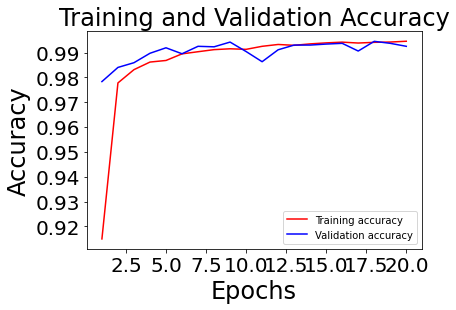

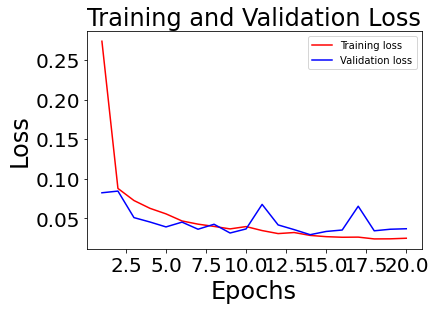

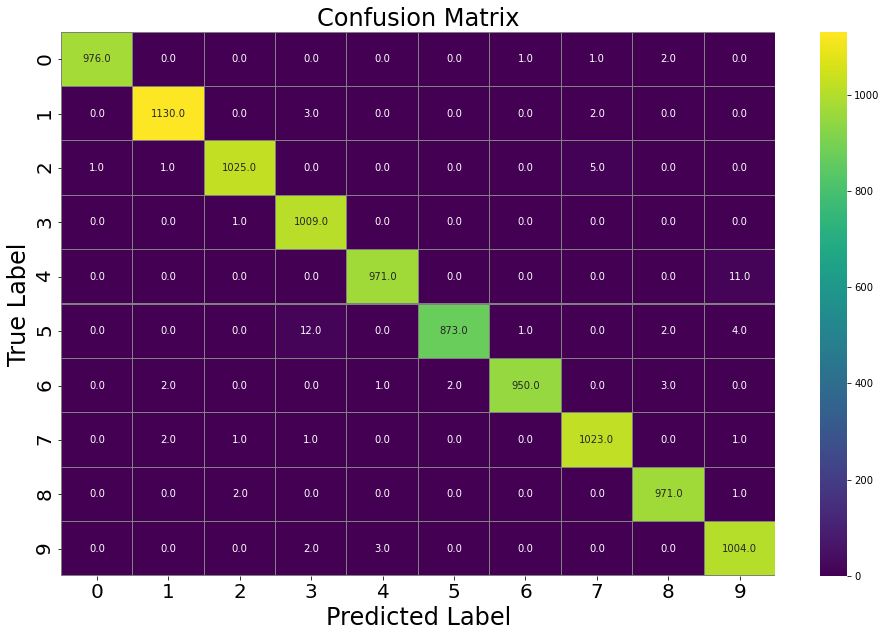

Saved model to disk


In [12]:
# Train VGG16 on MNIST dataset
main("vgg16-train-mnist", "relu")

In [15]:
# Test VGG16 on MNIST dataset
main("test-vgg16-mnist")

Loaded model from disk
[0.022620876338965788, 0.9944]


(50000, 28, 28, 1)
  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 234s 117ms/step - loss: 2.0939 - accuracy: 0.3032 - val_loss: 1.9517 - val_accuracy: 0.4643
Epoch 2/20
2000/2000 [==============================] - 218s 109ms/step - loss: 1.1514 - accuracy: 0.6086 - val_loss: 0.6253 - val_accuracy: 0.8032
Epoch 3/20
2000/2000 [==============================] - 218s 109ms/step - loss: 0.6040 - accuracy: 0.8033 - val_loss: 0.2942 - val_accuracy: 0.9049
Epoch 4/20
2000/2000 [==============================] - 220s 110ms/step - loss: 0.3746 - accuracy: 0.8829 - val_loss: 0.4557 - val_accuracy: 0.8669
Epoch 5/20
2000/2000 [==============================] - 219s 110ms/step - loss: 0.2890 - accuracy: 0.9133 - val_loss: 0.1539 - val_accuracy: 0.9527
Epoch 6/20
2000/2000 [==============================] - 216s 108ms/step - loss: 0.1771 - accuracy: 0.9462 - val_loss: 0.0974 - val_accuracy: 0.9722
Epoch 7/20
2000/2000

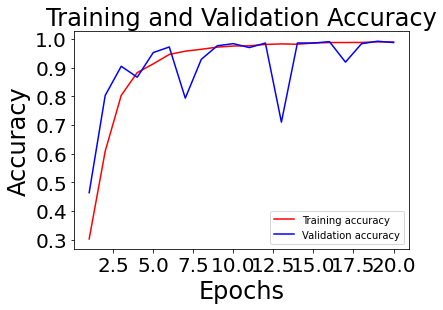

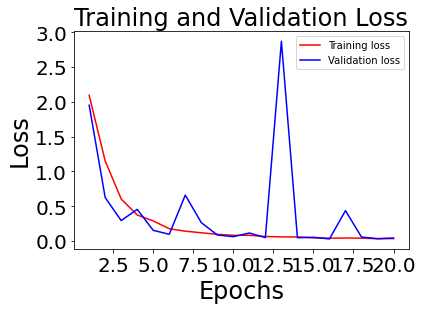

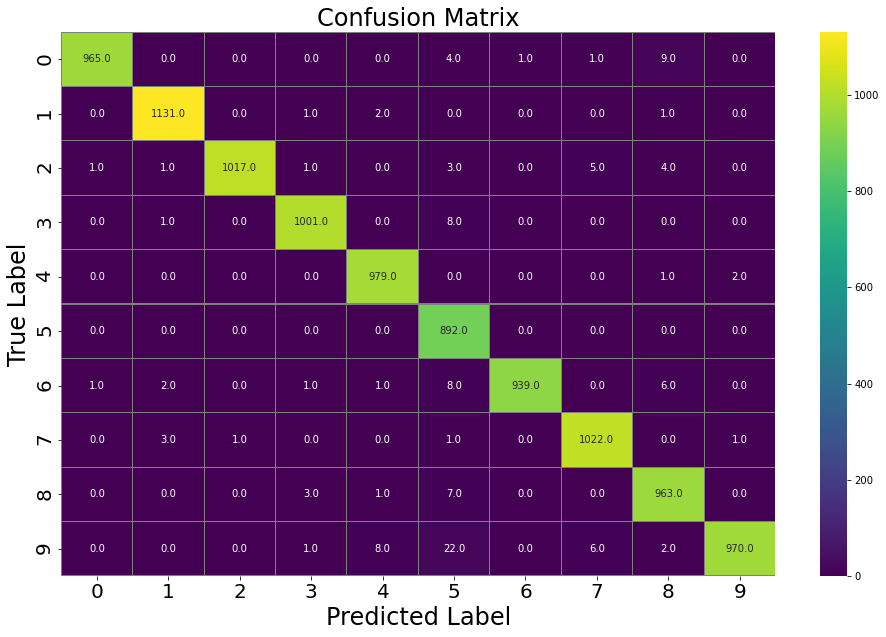

Saved model to disk


In [39]:
main("resnet152_train")

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 41s 21ms/step - loss: 2.0051 - accuracy: 0.2892 - val_loss: 2.3356 - val_accuracy: 0.0961
Epoch 2/20
2000/2000 [==============================] - 35s 17ms/step - loss: 1.0828 - accuracy: 0.6248 - val_loss: 2.4473 - val_accuracy: 0.1009
Epoch 3/20
2000/2000 [==============================] - 35s 18ms/step - loss: 0.5154 - accuracy: 0.8279 - val_loss: 2.1315 - val_accuracy: 0.1355
Epoch 4/20
2000/2000 [==============================] - 35s 18ms/step - loss: 0.3021 - accuracy: 0.9044 - val_loss: 0.1964 - val_accuracy: 0.9478
Epoch 5/20
2000/2000 [==============================] - 35s 17ms/step - loss: 0.2050 - accuracy: 0.9349 - val_loss: 0.1293 - val_accuracy: 0.9590
Epoch 6/20
2000/2000 [==============================] - 35s 18ms/step - loss: 0.1560 - accuracy: 0.9520 - val_loss: 0.1032 - val_accuracy: 0.9689
Epoch 7/20
2000/2000 [=============================

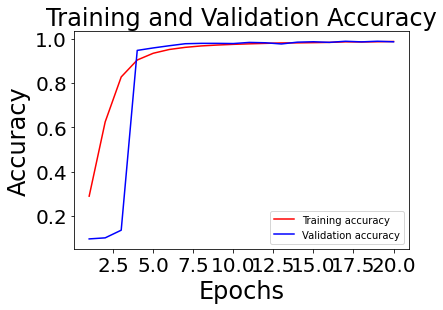

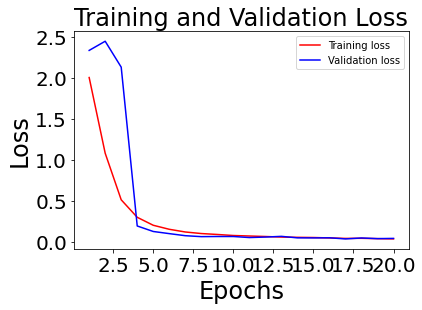

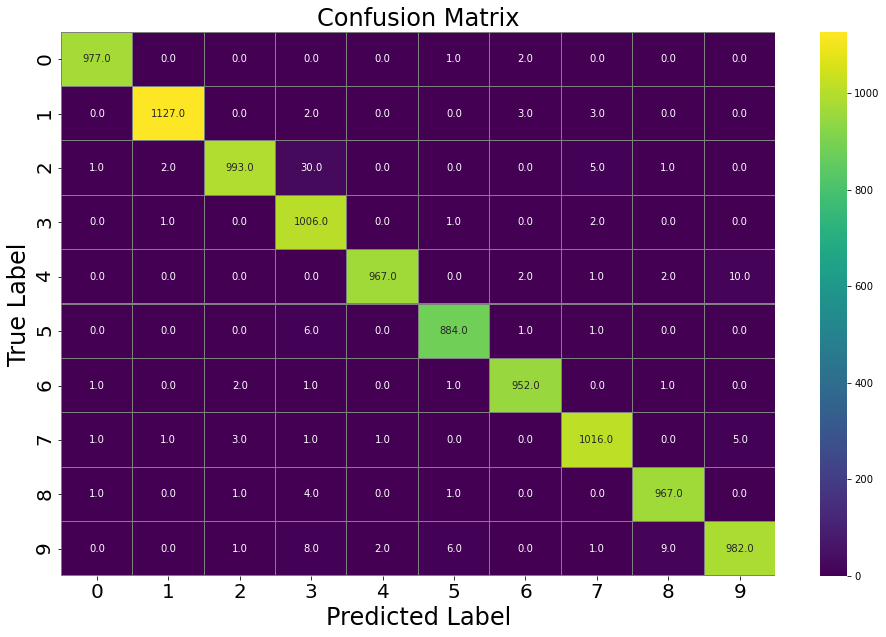

Saved model to disk


In [58]:
main("MobileNetV2_train")

In [16]:
main("test-resnet152-mnist")

Loaded model from disk
[0.034106933794682846, 0.9897]


In [17]:
main("test-MobileNetV2-mnist")

Loaded model from disk
[0.0427186423573643, 0.987]


  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 68s 34ms/step - loss: 2.3533 - accuracy: 0.1033 - val_loss: 2.3388 - val_accuracy: 0.1064
Epoch 2/20
2000/2000 [==============================] - 66s 33ms/step - loss: 2.3301 - accuracy: 0.1036 - val_loss: 2.3241 - val_accuracy: 0.0990
Epoch 3/20
2000/2000 [==============================] - 65s 33ms/step - loss: 2.3286 - accuracy: 0.1014 - val_loss: 2.3138 - val_accuracy: 0.1064
Epoch 4/20
2000/2000 [==============================] - 64s 32ms/step - loss: 2.3302 - accuracy: 0.1042 - val_loss: 2.3271 - val_accuracy: 0.1064
Epoch 5/20
2000/2000 [==============================] - 65s 32ms/step - loss: 2.3302 - accuracy: 0.1025 - val_loss: 2.3252 - val_accuracy: 0.1030
Epoch 6/20
2000/2000 [==============================] - 65s 32ms/step - loss: 2.3289 - accuracy: 0.1053 - val_loss: 2.3173 - val_accuracy: 0.0961
Epoch 7/20
2000/2000 [=============================

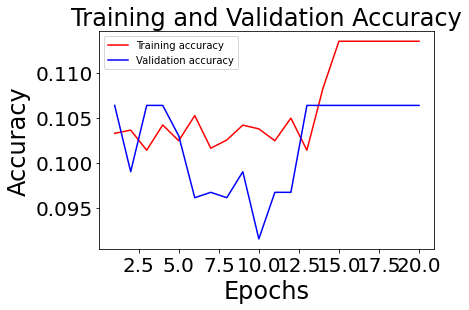

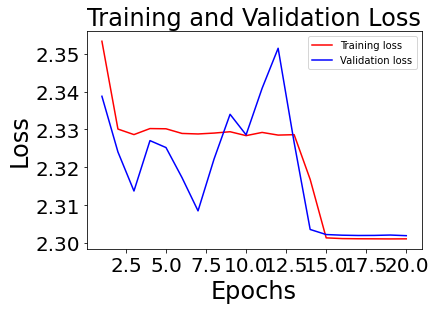

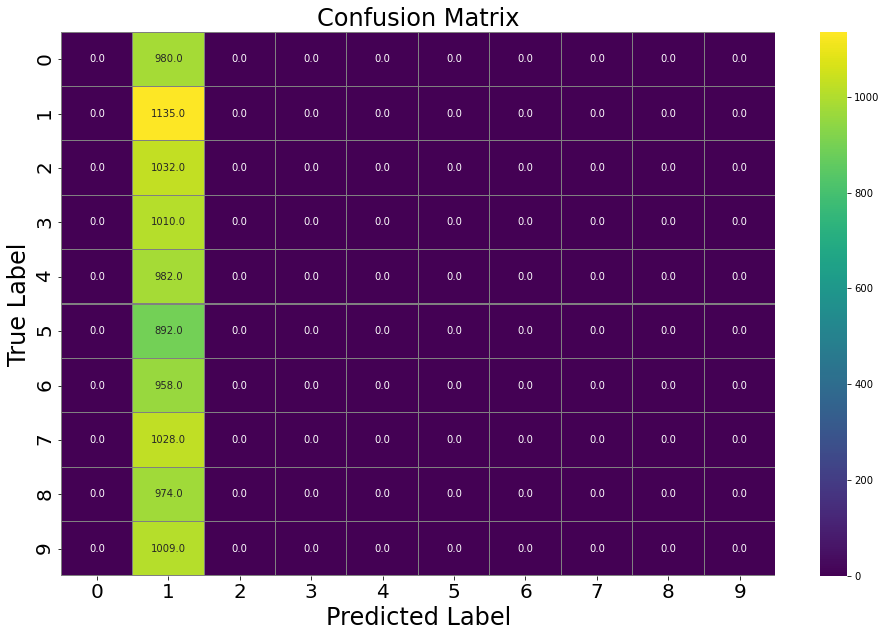

Saved model to disk


In [20]:
main("vgg16-train-mnist", "sigmoid")

In [23]:
main("test-vgg16-mnist")

Loaded model from disk
[2.3329240837097167, 0.1135]


  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 68s 34ms/step - loss: 0.2514 - accuracy: 0.9238 - val_loss: 0.1094 - val_accuracy: 0.9692
Epoch 2/20
2000/2000 [==============================] - 69s 35ms/step - loss: 0.1398 - accuracy: 0.9643 - val_loss: 0.1156 - val_accuracy: 0.9729
Epoch 3/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0948 - accuracy: 0.9760 - val_loss: 0.0700 - val_accuracy: 0.9832
Epoch 4/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0794 - accuracy: 0.9803 - val_loss: 0.0488 - val_accuracy: 0.9876
Epoch 5/20
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0705 - accuracy: 0.9817 - val_loss: 0.0465 - val_accuracy: 0.9887
Epoch 6/20
2000/2000 [==============================] - 69s 35ms/step - loss: 0.0602 - accuracy: 0.9840 - val_loss: 0.0516 - val_accuracy: 0.9863
Epoch 7/20
2000/2000 [=============================

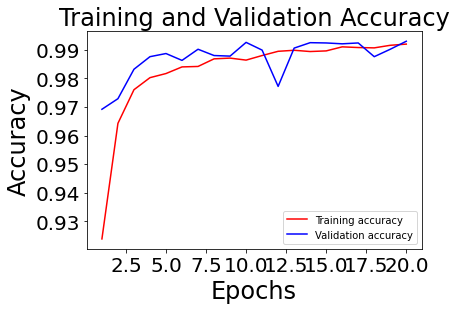

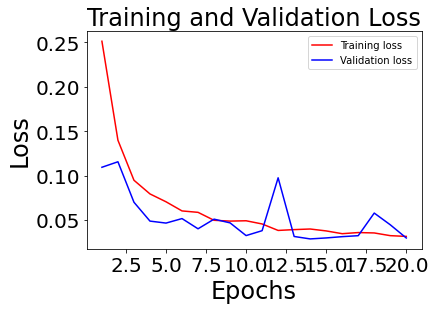

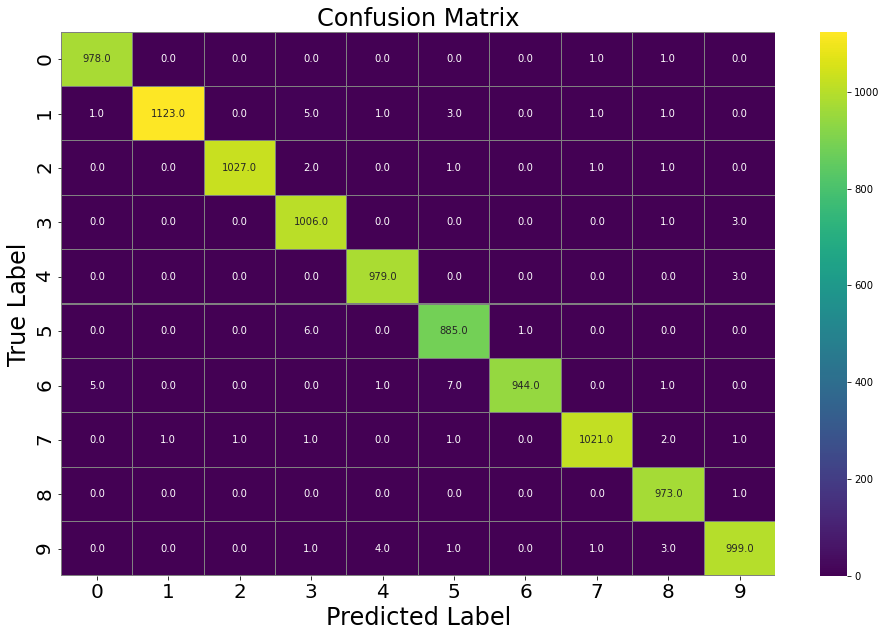

Saved model to disk


In [24]:
main("vgg16-train-mnist", "tanh")

In [25]:
main("test-vgg16-mnist")

Loaded model from disk
[0.028700061143329368, 0.9935]


  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 235s 118ms/step - loss: 2.1399 - accuracy: 0.2884 - val_loss: 2.0623 - val_accuracy: 0.4335
Epoch 2/20
2000/2000 [==============================] - 218s 109ms/step - loss: 1.1808 - accuracy: 0.5976 - val_loss: 0.9678 - val_accuracy: 0.7274
Epoch 3/20
2000/2000 [==============================] - 219s 109ms/step - loss: 0.6228 - accuracy: 0.7970 - val_loss: 0.4056 - val_accuracy: 0.8630
Epoch 4/20
2000/2000 [==============================] - 216s 108ms/step - loss: 0.3829 - accuracy: 0.8799 - val_loss: 0.6770 - val_accuracy: 0.8521
Epoch 5/20
2000/2000 [==============================] - 217s 109ms/step - loss: 0.2731 - accuracy: 0.9176 - val_loss: 0.1520 - val_accuracy: 0.9565
Epoch 6/20
2000/2000 [==============================] - 217s 109ms/step - loss: 0.1998 - accuracy: 0.9398 - val_loss: 0.1069 - val_accuracy: 0.9685
Epoch 7/20
2000/2000 [=================

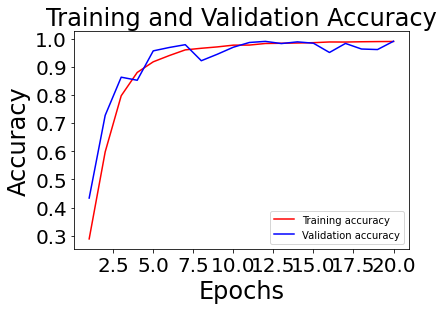

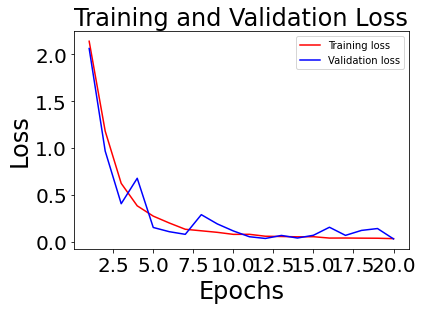

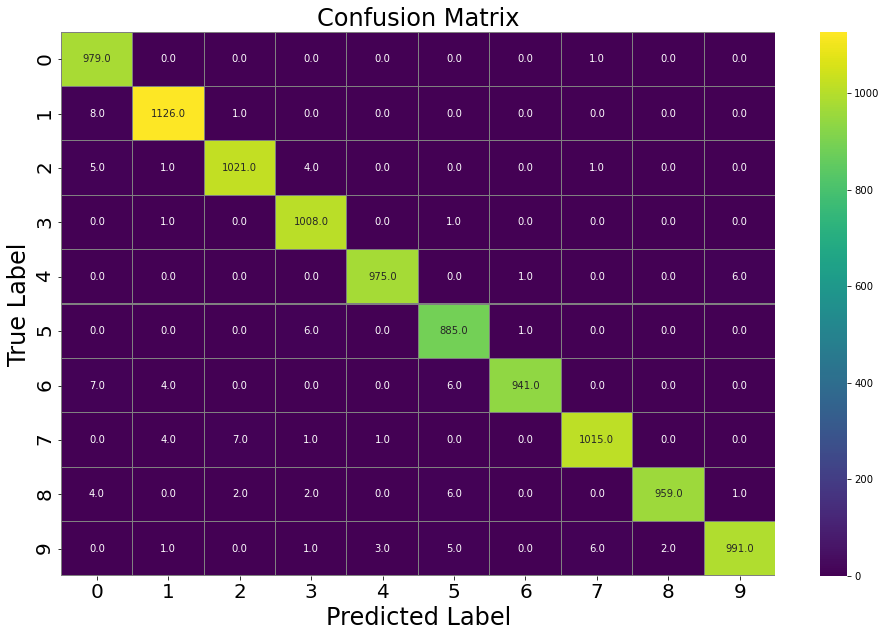

Saved model to disk


In [26]:
main("resnet152_train", "avg")

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 232s 116ms/step - loss: 2.0191 - accuracy: 0.3254 - val_loss: 3.1371 - val_accuracy: 0.4654
Epoch 2/20
2000/2000 [==============================] - 217s 109ms/step - loss: 1.0647 - accuracy: 0.6397 - val_loss: 1.2303 - val_accuracy: 0.6770
Epoch 3/20
2000/2000 [==============================] - 217s 109ms/step - loss: 0.5682 - accuracy: 0.8151 - val_loss: 0.3223 - val_accuracy: 0.9047
Epoch 4/20
2000/2000 [==============================] - 216s 108ms/step - loss: 0.3469 - accuracy: 0.8918 - val_loss: 0.3402 - val_accuracy: 0.9004
Epoch 5/20
2000/2000 [==============================] - 216s 108ms/step - loss: 0.2331 - accuracy: 0.9302 - val_loss: 8.3665 - val_accuracy: 0.8389
Epoch 6/20
2000/2000 [==============================] - 237s 119ms/step - loss: 0.1893 - accuracy: 0.9449 - val_loss: 0.1021 - val_accuracy: 0.9692
Epoch 7/20
2000/2000 [=================

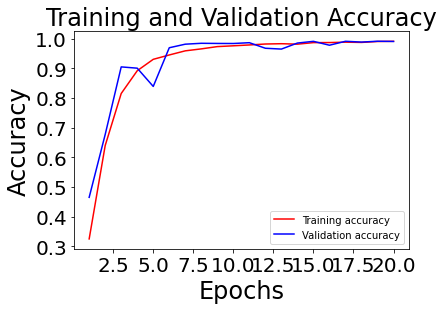

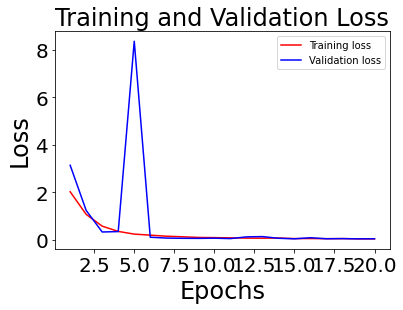

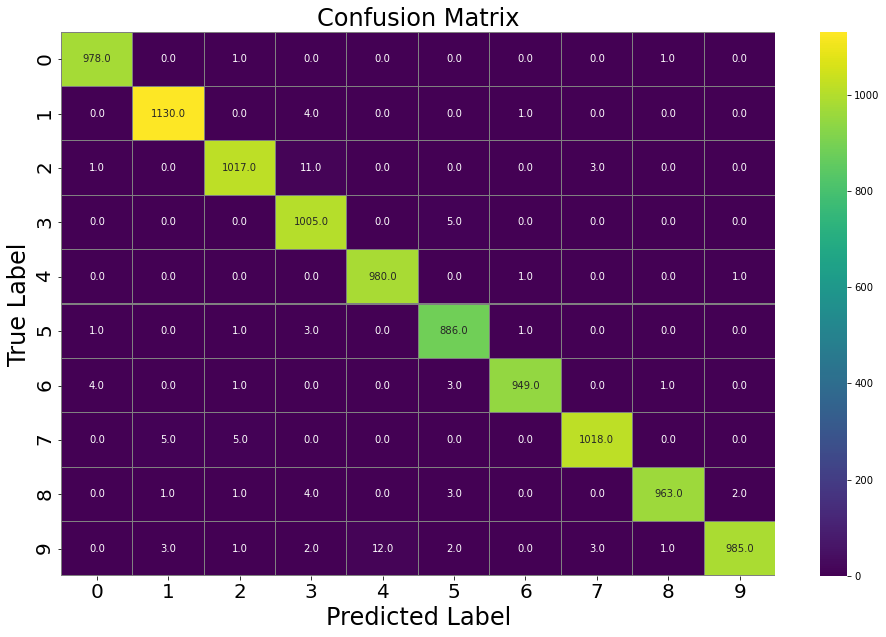

Saved model to disk


In [27]:
main("resnet152_train", "max")

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 68s 34ms/step - loss: 2.0525 - accuracy: 0.2622 - val_loss: 2.3105 - val_accuracy: 0.0990
Epoch 2/20
2000/2000 [==============================] - 59s 29ms/step - loss: 1.2837 - accuracy: 0.5435 - val_loss: 2.3557 - val_accuracy: 0.1009
Epoch 3/20
2000/2000 [==============================] - 59s 29ms/step - loss: 0.6409 - accuracy: 0.7857 - val_loss: 1.8849 - val_accuracy: 0.3017
Epoch 4/20
2000/2000 [==============================] - 58s 29ms/step - loss: 0.3578 - accuracy: 0.8849 - val_loss: 0.2522 - val_accuracy: 0.9219
Epoch 5/20
2000/2000 [==============================] - 59s 29ms/step - loss: 0.2330 - accuracy: 0.9282 - val_loss: 0.1723 - val_accuracy: 0.9444
Epoch 6/20
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1681 - accuracy: 0.9481 - val_loss: 0.1120 - val_accuracy: 0.9635
Epoch 7/20
2000/2000 [=============================

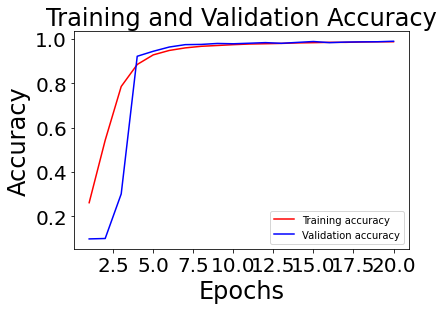

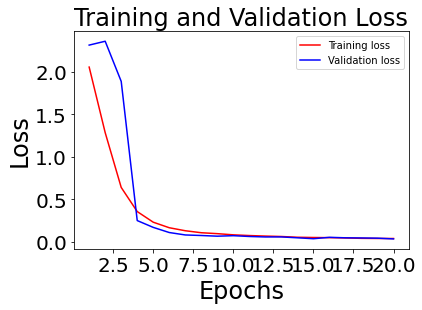

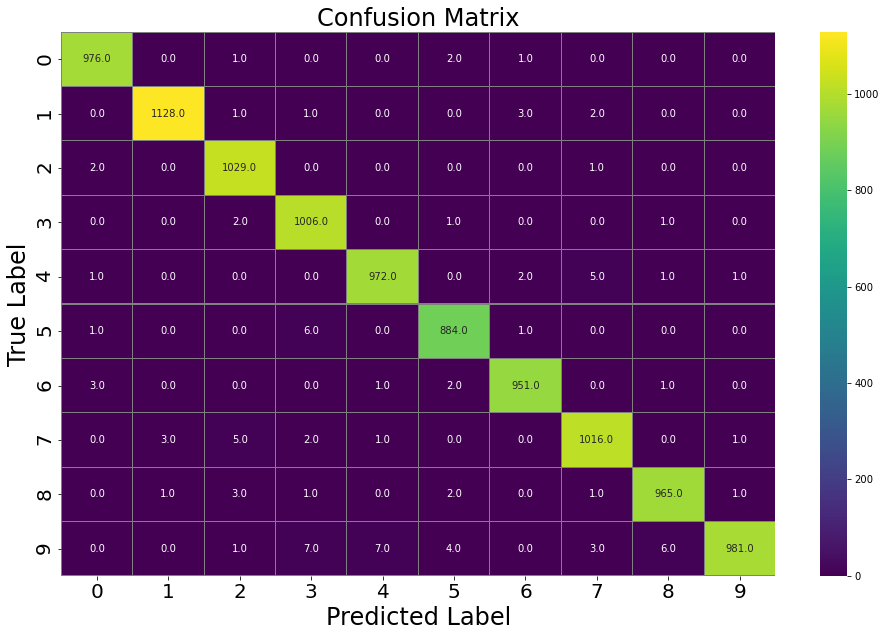

Saved model to disk


In [29]:
main("MobileNetV2_train", "avg")

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/20
2000/2000 [==============================] - 41s 21ms/step - loss: 1.9816 - accuracy: 0.2925 - val_loss: 2.3353 - val_accuracy: 0.1009
Epoch 2/20
2000/2000 [==============================] - 36s 18ms/step - loss: 1.0895 - accuracy: 0.6195 - val_loss: 2.4572 - val_accuracy: 0.1009
Epoch 3/20
2000/2000 [==============================] - 35s 18ms/step - loss: 0.5040 - accuracy: 0.8331 - val_loss: 2.1943 - val_accuracy: 0.2375
Epoch 4/20
2000/2000 [==============================] - 36s 18ms/step - loss: 0.2868 - accuracy: 0.9080 - val_loss: 0.2061 - val_accuracy: 0.9430
Epoch 5/20
2000/2000 [==============================] - 36s 18ms/step - loss: 0.1948 - accuracy: 0.9388 - val_loss: 0.1533 - val_accuracy: 0.9552
Epoch 6/20
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1461 - accuracy: 0.9546 - val_loss: 0.0909 - val_accuracy: 0.9716
Epoch 7/20
2000/2000 [=============================

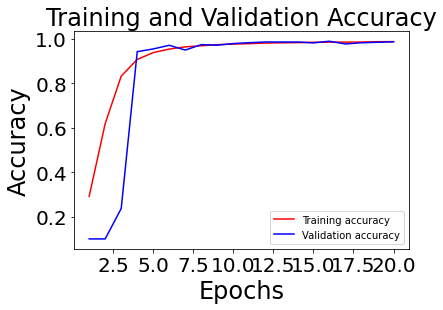

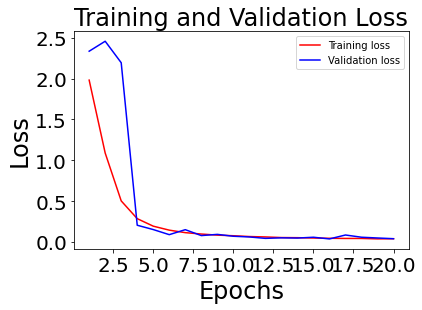

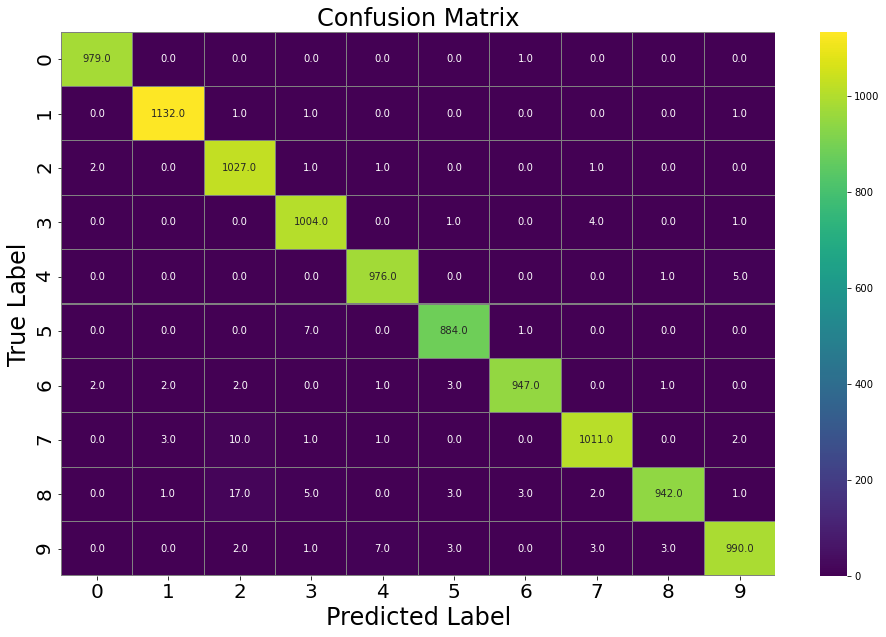

Saved model to disk


In [30]:
main("MobileNetV2_train", "max")